### Stroke Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv("Stroke_Prediction.csv")
df

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,57008,Female,25578.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46657,Male,5128.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56541,Female,3652.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5710,Female,20446.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28974,Female,29930.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,28894,Male,14615.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [3]:
df.groupby('Stroke').count()
df.groupby('Residence').count()
df.groupby('Type_Of_Work').count()

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
Type_Of_Work,,,,,,,,,,,
Govt_job,5440,5440,5440,5440,5440,5440,5440,5440,5244,4346,5440
Never_worked,177,177,177,177,177,177,177,177,176,101,177
Private,24834,24834,24834,24834,24834,24834,24834,24834,23984,19585,24834
Self-employed,6793,6793,6793,6793,6793,6793,6793,6793,6474,5445,6793
children,6156,6156,6156,6156,6156,6156,6156,6156,6060,631,6156


### Missing value: 
1. BMI missing 1462, which associate with other feature, we could filled the missing values by multi-imputation. 
2. Smoking_status: ~25% missing, it might couse some bias.  
3. Age has some outlier(500 years old!?), we errase those value.

In [3]:
# missing value
df[list(df.columns.values)].isnull().sum()

ID                    0
Gender                0
Age_In_Days           0
Hypertension          0
Heart_Disease         0
Ever_Married          0
Type_Of_Work          0
Residence             0
Avg_Glucose           0
BMI                1462
Smoking_Status    13292
Stroke                0
dtype: int64

<Axes: xlabel='BMI', ylabel='Age_In_Days'>

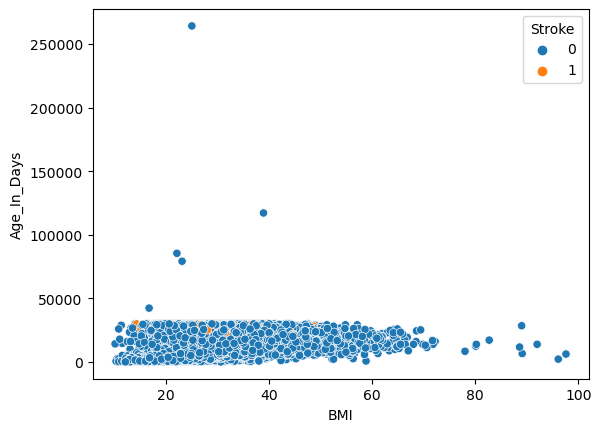

In [61]:
sns.scatterplot(df, y ='Age_In_Days', x="BMI", hue='Stroke')

In [56]:
df[df['Age_In_Days']>40000]

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
1342,58414,Female,85451.0,0,0,No,Private,Rural,65.30,22.1,smokes,0
3786,69795,Male,42349.0,0,0,No,Never_worked,Urban,64.29,16.7,NaN,0
8155,35313,Male,264301.0,0,0,No,Govt_job,Urban,80.31,25.0,NaN,0
18177,31212,Female,117179.0,0,0,Yes,Govt_job,Rural,84.39,38.9,never smoked,0
26716,70730,Female,79231.0,0,0,No,Private,Rural,77.62,23.1,formerly smoked,0


### Clean up dataset

In [3]:
# df for errasing outlier: Age value > 40000
df1 = df[(df['Age_In_Days']<40000)&(df['Gender']!='Other')]

# convert categorical features to dummy variables
sex = pd.get_dummies(df1['Gender'],drop_first=True)
merry = pd.get_dummies(df1['Ever_Married'],drop_first=True).rename(columns={"Yes":"merry"})
work = pd.get_dummies(df1['Type_Of_Work'],drop_first=True).rename(columns={"Private":"Private_work","Self-employed":"Self-employed_work","children":"child_nowork"})
resid = pd.get_dummies(df1['Residence'],drop_first=True).rename(columns={"Urban":"city"})
smoke = pd.get_dummies(df1['Smoking_Status'],drop_first=True)

df2 = df1[['ID','BMI','Age_In_Days','Hypertension','Heart_Disease','Avg_Glucose','Stroke']]

df_in = pd.concat([df2,sex,merry,work,resid,smoke],axis=1)
df_in

,ID,BMI,Age_In_Days,Hypertension,Heart_Disease,Avg_Glucose,Stroke,Male,merry,Never_worked,Private_work,Self-employed_work,child_nowork,city,never smoked,smokes
0,31153,18.0,1104.0,0,0,95.12,0,1,0,0,0,0,1,0,0,0
1,30650,39.2,21204.0,1,0,87.96,0,1,1,0,1,0,0,1,1,0
2,17412,17.6,2928.0,0,0,110.89,0,0,0,0,1,0,0,1,0,0
3,57008,35.9,25578.0,0,0,69.04,0,0,1,0,1,0,0,0,0,0
4,46657,19.1,5128.0,0,0,161.28,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56541,20.4,3652.0,0,0,58.64,0,0,0,0,0,0,1,1,1,0
43396,5710,55.4,20446.0,0,0,213.61,0,0,1,0,0,0,0,1,0,0
43397,28974,28.9,29930.0,1,0,91.94,0,0,1,0,1,0,0,1,0,0
43398,28894,33.2,14615.0,0,0,99.16,0,1,1,0,1,0,0,1,1,0


### Imputation the missing value of BMI
missing feature imputation 
0. with IterativeImputer+
1. BayesianRidge: regularized linear regression
2. RandomForestRegressor: Forests of randomized trees regression
3. make_pipeline (Nystroem, Ridge): a pipeline with the expansion of a degree 2 polynomial kernel and regularized linear regression
4. KNeighborsRegressor: comparable to other KNN imputation approaches

(BayesianRidge and RandomForestRegressor might give the best results.)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [11]:
list(df_inB.columns.values[1:])

['Age_In_Days',
 'Hypertension',
 'Heart_Disease',
 'Avg_Glucose',
 'Stroke',
 'Male',
 'merry',
 'Never_worked',
 'Private_work',
 'Self-employed_work',
 'child_nowork',
 'city']

In [6]:
# Split the DataFrame into two parts: one with missing values in BMI and one without
df_inB = df_in.drop(['ID','never smoked','smokes'],axis=1)
df_missing = df_inB[df_inB['BMI'].isnull()]
df_not_missing = df_inB[~df_inB['BMI'].isnull()]

# Define X and y for model training
X = df_not_missing[list(df_inB.columns.values)[1:]]
y = df_not_missing['BMI']

In [7]:
# Train a machine learning model to predict BMI based on other features
model = RandomForestRegressor()
model.fit(X, y)

# Use the trained model to predict missing values
X_missing = df_missing[list(df_inB.columns.values)[1:]]
predicted_values = model.predict(X_missing)

# Fill in the missing values in the original DataFrame
df_in.loc[df_in['BMI'].isnull(), 'BMI'] = predicted_values

df_in

,ID,BMI,Age_In_Days,Hypertension,Heart_Disease,Avg_Glucose,Stroke,Male,merry,Never_worked,Private_work,Self-employed_work,child_nowork,city,never smoked,smokes
0,31153,18.0,1104.0,0,0,95.12,0,1,0,0,0,0,1,0,0,0
1,30650,39.2,21204.0,1,0,87.96,0,1,1,0,1,0,0,1,1,0
2,17412,17.6,2928.0,0,0,110.89,0,0,0,0,1,0,0,1,0,0
3,57008,35.9,25578.0,0,0,69.04,0,0,1,0,1,0,0,0,0,0
4,46657,19.1,5128.0,0,0,161.28,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56541,20.4,3652.0,0,0,58.64,0,0,0,0,0,0,1,1,1,0
43396,5710,55.4,20446.0,0,0,213.61,0,0,1,0,0,0,0,1,0,0
43397,28974,28.9,29930.0,1,0,91.94,0,0,1,0,1,0,0,1,0,0
43398,28894,33.2,14615.0,0,0,99.16,0,1,1,0,1,0,0,1,1,0


Great! We have a clean dataset!

### Imbalanced data
The population of class Stroke==1 is 50 times less than class Stroke==0! 
Results may be biased towards the majority class.

In [16]:
df_in.groupby('Stroke').count()

,ID,BMI,Age_In_Days,Hypertension,Heart_Disease,Avg_Glucose,Male,merry,Never_worked,Private_work,Self-employed_work,child_nowork,city
Stroke,,,,,,,,,,,,,
0,42601,42601,42601,42601,42601,42601,42601,42601,42601,42601,42601,42601,42601
1,783,783,783,783,783,783,783,783,783,783,783,783,783


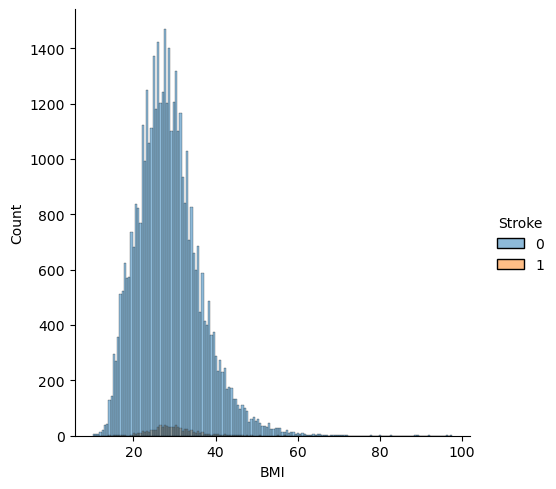

In [24]:
sns.displot(df_in, x = 'BMI', hue='Stroke')

### p-value
1. H0: [Stroke=0]==[Stroke=1]
2. H1: [Stroke=0]!=[Stroke=1]

In [8]:
from sklearn.utils import resample
from scipy import stats

# Separate majority and minority classes
df_majority = df_in[df_in['Stroke'] == 0]
df_minority = df_in[df_in['Stroke'] == 1]
# Undersample the majority class
undersampled_majority = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
oversampled_minority = resample(df_minority, n_samples=len(df_majority), random_state=42)

In [78]:
stats.pearsonr(undersampled_majority['BMI'], df_minority['BMI'])[1]
#df_cov['p_value'][i] = stats.pearsonr(undersampled_majority[df_cov.index[i]], df_minority[df_cov.index[i]])[1]

0.08647065910014202

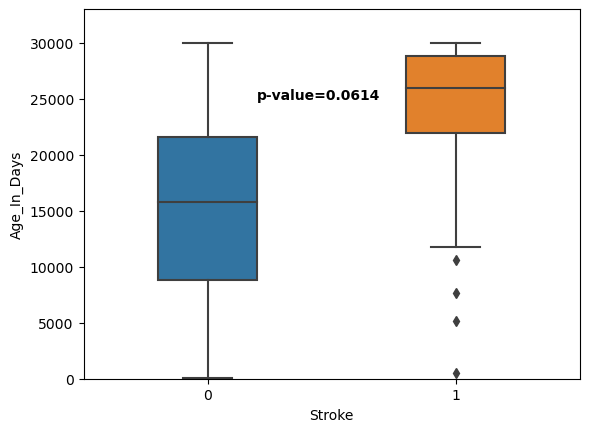

p-value: 0.06139818700799861


In [9]:
sns.boxplot(data= df_in, y ='Age_In_Days', x = 'Stroke', width=0.4)
plt.text(0+0.2, 25000, "p-value=0.0614", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim([-10.0, 33000])
plt.show()
print("p-value:", stats.pearsonr(undersampled_majority['Age_In_Days'], df_minority['Age_In_Days'])[1])

p-value 0.06 < 0.07,  have difference.

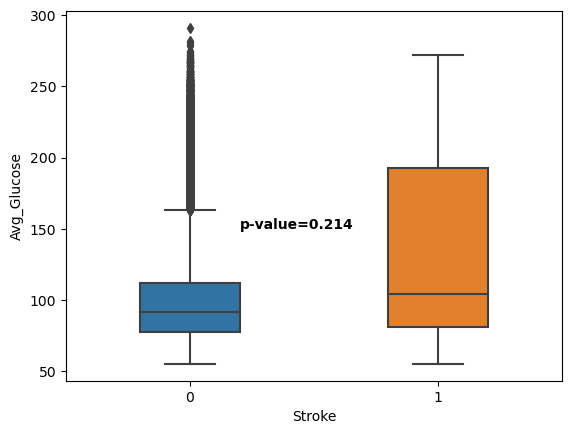

p-value: 0.21407556383843337


In [10]:
sns.boxplot(data= df[df['Age_In_Days']<40000], y ='Avg_Glucose', x = 'Stroke', width=0.4)
plt.text(0+0.2, 150, "p-value=0.214", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()
print("p-value:", stats.pearsonr(undersampled_majority['Avg_Glucose'], df_minority['Avg_Glucose'])[1])

p-value > 0.07, don't have significant difference.

p-value: 0.08294878481863227


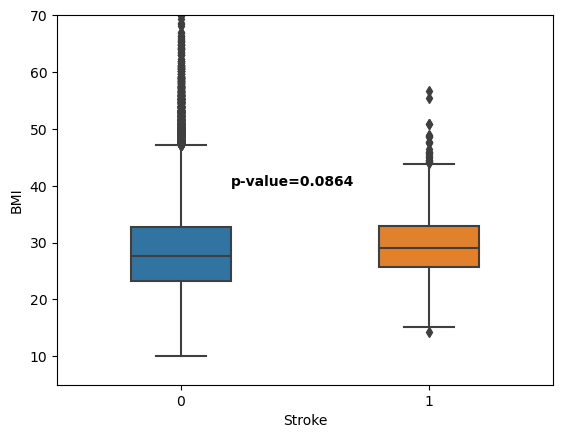

In [11]:
sns.boxplot(data= df[df['Age_In_Days']<40000], y ='BMI', x = 'Stroke', width=0.4)
plt.text(0+0.2, 40, "p-value=0.0864", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim([5, 70])
print("p-value:", stats.pearsonr(undersampled_majority['BMI'], df_minority['BMI'])[1])
plt.show()

p-value 0.08 > 0.07, don't have significant difference.

### Scaling
Many machine learning algorithms work better when features are on a relatively similar scale and close to normally distributed.
1. Standard Scaler: scales features such that the distribution is centered(mean) around 0, with a standard deviation of 1.
2. Robust Scaler: uses median and interquartile range. It answer how far between each data points and "median".
3. Normalization(MinMax Scaler): 0-1


BMI, Age, Glucose are like normal distributions, we use Standard Scaler.

In [48]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #RobustScaler
#robust_scaler = RobustScaler()
scaler = StandardScaler()
#scaler = MinMaxScaler()

# calculate median and IQR  
scaler.fit(df_in[['BMI','Age_In_Days','Avg_Glucose']])

#robust_scaler.fit(df_in[independent_variables])

# scale all data points using median and IQR
#robust_scaled_data = robust_scaler.transform(df_in[['BMI','Age_In_Days','Avg_Glucose']])
scaled_data = scaler.transform(df_in[['BMI','Age_In_Days','Avg_Glucose']])

# transfer to dataframe for Cov
df_ins = pd.DataFrame(scaled_data, columns = ['BMI','Age_In_Days','Avg_Glucose'])
df_ins = df_ins.join(df_in[['Hypertension','Heart_Disease','Male','Stroke','merry','Never_worked','Private_work','Self-employed_work','child_nowork','city']].reset_index())
df_ins

,BMI,Age_In_Days,Avg_Glucose,index,Hypertension,Heart_Disease,Male,Stroke,merry,Never_worked,Private_work,Self-employed_work,child_nowork,city
0,-1.387561,-1.743114,-0.217327,0,0,0,1,0,0,0,0,0,1,0
1,1.366511,0.701675,-0.383391,1,1,0,1,0,1,0,1,0,0,1
2,-1.439525,-1.521258,0.148432,2,0,0,0,0,0,0,1,0,0,1
3,0.937811,1.233690,-0.822209,3,0,0,0,0,1,0,1,0,0,0
4,-1.244661,-1.253669,1.317144,4,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43379,-1.075779,-1.433197,-1.063419,43395,0,0,0,0,0,0,0,0,1,1
43380,3.471037,0.609479,2.530851,43396,0,0,0,0,1,0,0,0,0,1
43381,0.028448,1.763030,-0.291082,43397,1,0,0,0,1,0,1,0,0,1
43382,0.587057,-0.099753,-0.123626,43398,0,0,1,0,1,0,1,0,0,1


#### test: What is the covarience between features and Stroke?

In [60]:
Cov = df_ins[independent_variables].cov()['Stroke']
Cov = Cov.sort_values(ascending=False)
df_cov = pd.DataFrame(Cov)
#df_cov = df_cov.rename(columns={"incident_diabetes": "Cov"})
df_cov

,Stroke
index,11.689169
Age_In_Days,0.020772
Stroke,0.017723
Avg_Glucose,0.010504
merry,0.004584
Heart_Disease,0.003222
BMI,0.003020
Self-employed_work,0.002960
Hypertension,0.002921
Male,0.000741


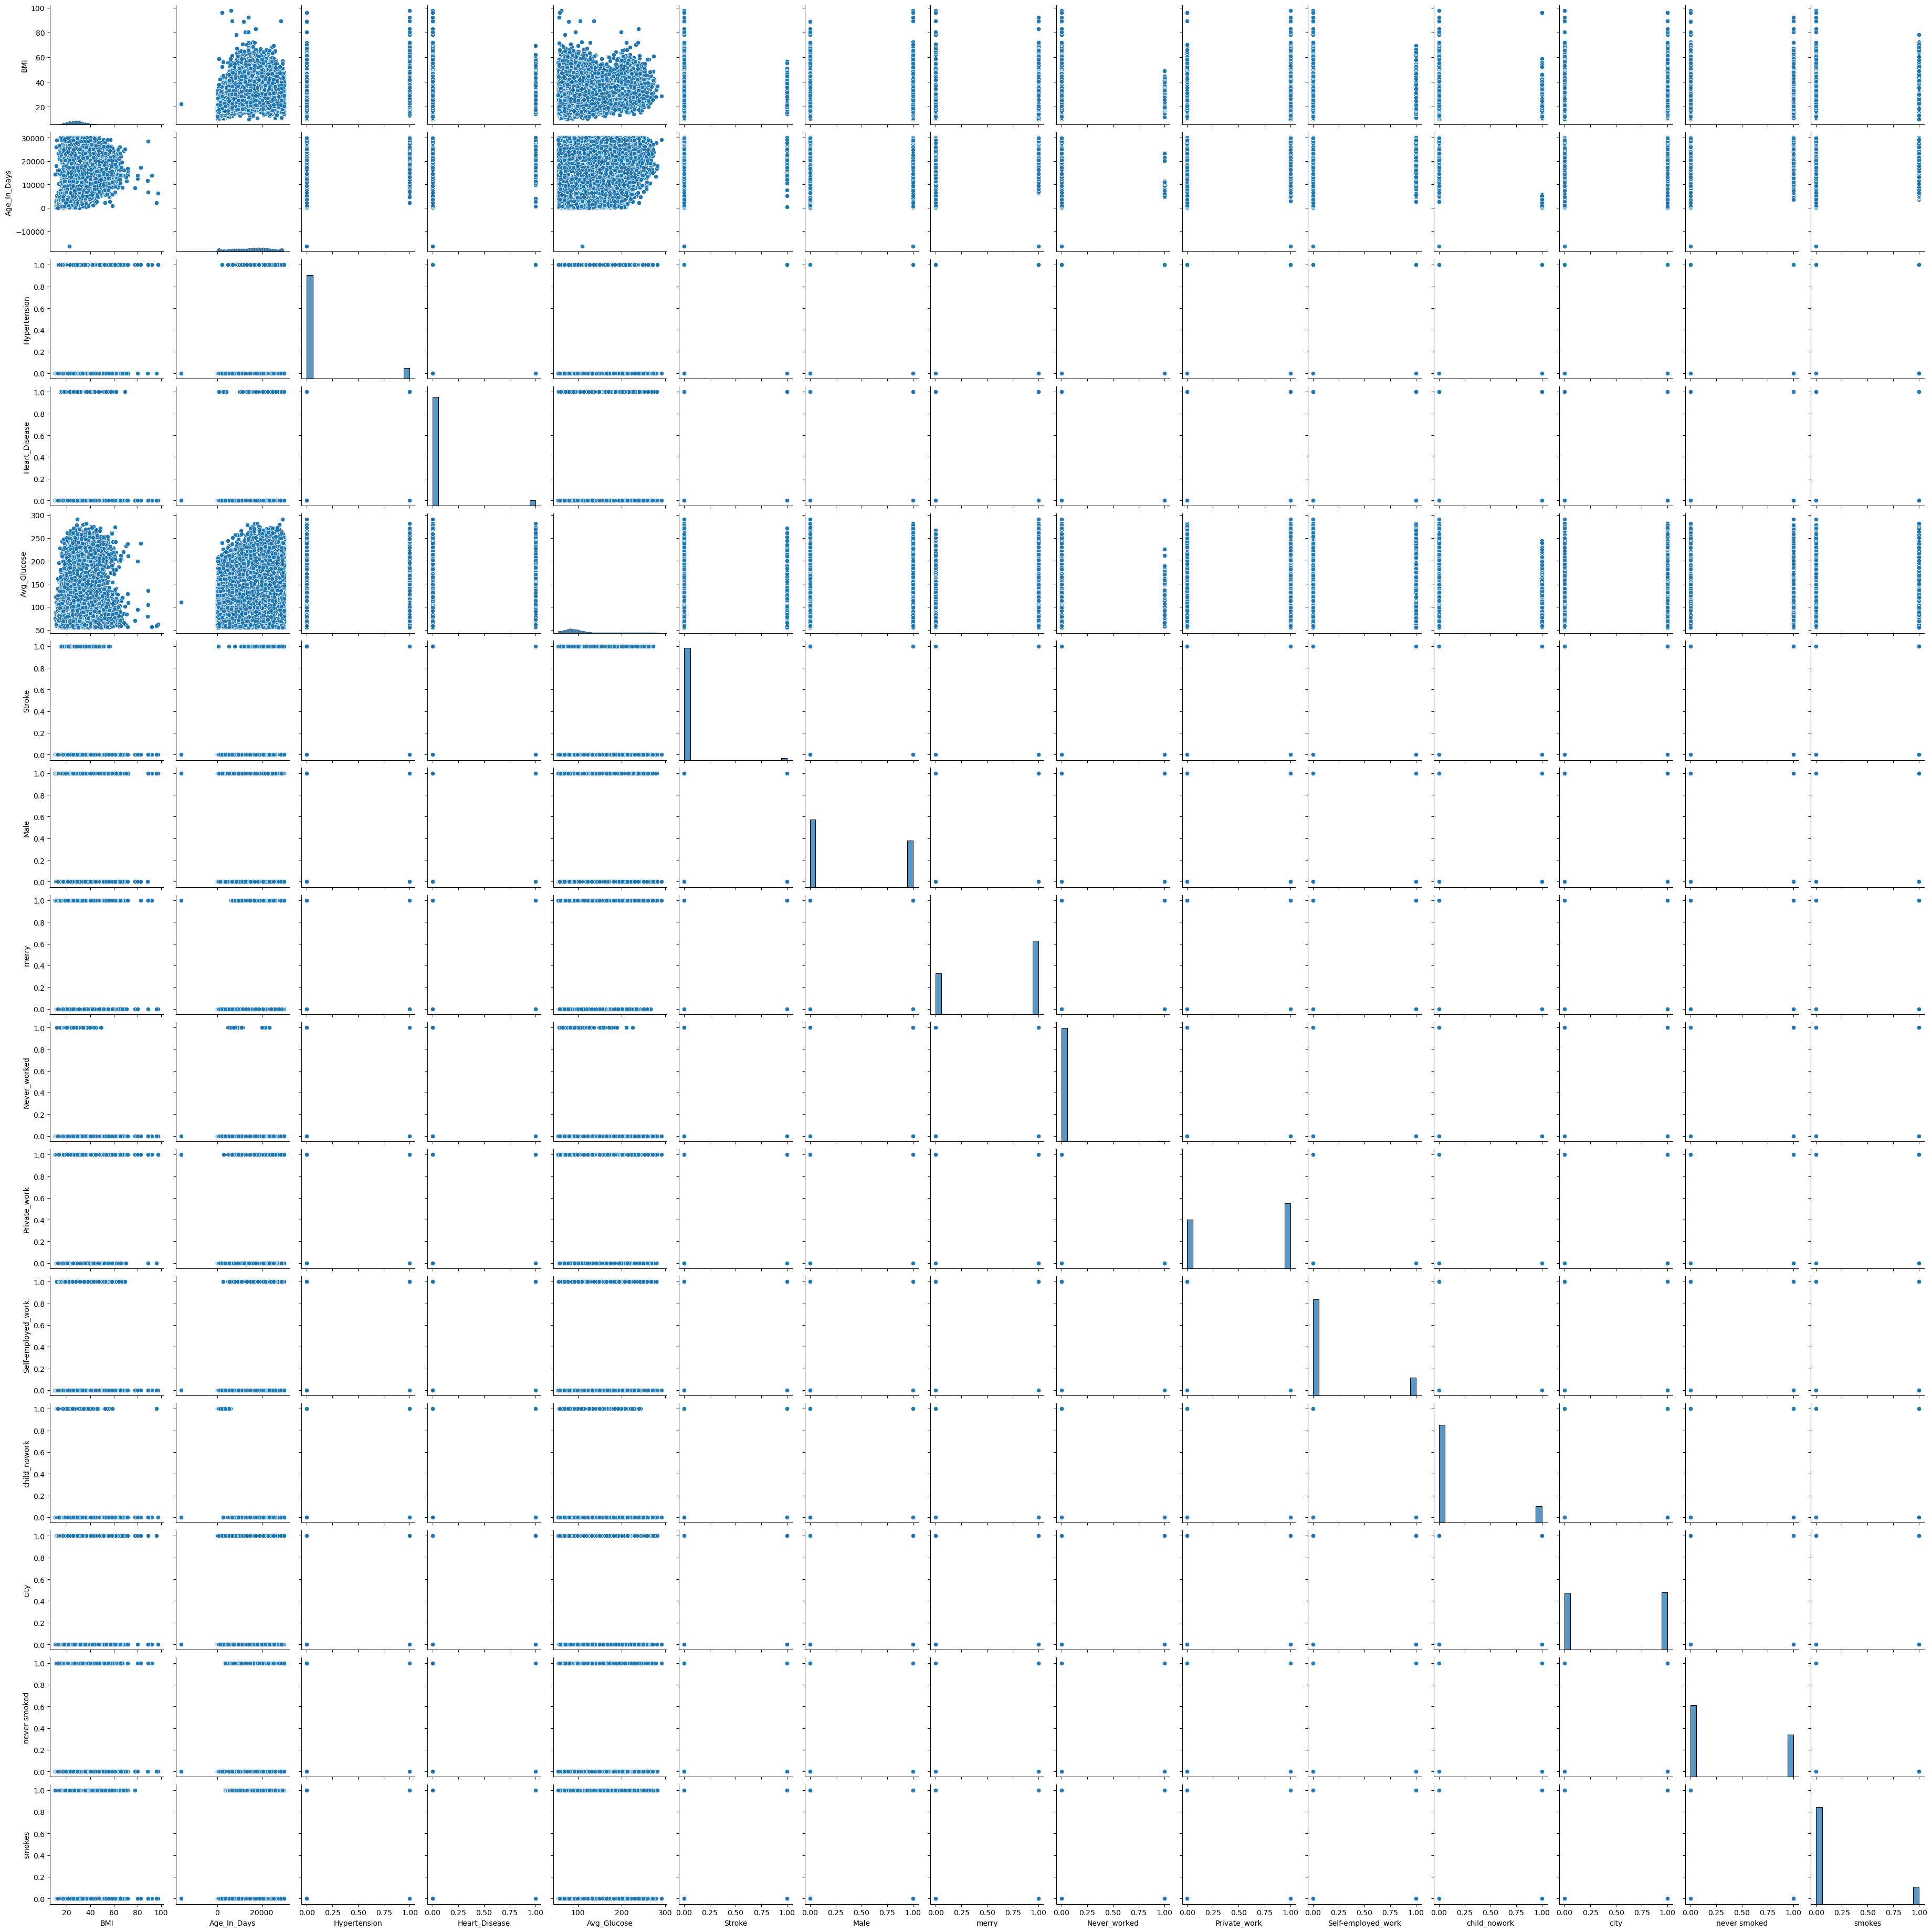

In [85]:
sns.pairplot(df_in.drop('ID',axis=1))

### Model training

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [16]:
X = df_in.drop(['ID','Stroke'],axis=1)
y = df_in['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=41)

#### Compare with defferent models

In [17]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
gb_clf = GradientBoostingClassifier()
xgb_clf = XGBClassifier()
voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf), ('gb',gb_clf),('xgb',xgb_clf)],
    voting='hard')

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

In [19]:
#Compare the models_part I
for clf in (log_clf, rnd_clf, svm_clf, gb_clf, xgb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)

    print("--train set performance--")
    print(clf.__class__.__name__) 
    print("accuracy score:",accuracy_score(y_train, y_train_pred))
    print("precision score:",precision_score(y_train, y_train_pred))
    print("recall score:",recall_score(y_train, y_train_pred))
    print("f1 score:",f1_score(y_train, y_train_pred))
    print("matthews corrcoef:", matthews_corrcoef(y_train,y_train_pred))
    print("Classification report:\n", classification_report(y_train,y_train_pred))
    
    print("--test set performance--")
    print(clf.__class__.__name__) 
    print("accuracy score:",accuracy_score(y_test, y_test_pred))
    print("precision score:",precision_score(y_test, y_test_pred))
    print("recall score:",recall_score(y_test, y_test_pred))
    print("f1 score:",f1_score(y_test, y_test_pred))
    print("matthews corrcoef:", matthews_corrcoef(y_test,y_test_pred))
    print("Classification report:\n", classification_report(y_test,y_test_pred))

--train set performance--
LogisticRegression
accuracy score: 0.9813292354975028
precision score: 0.25
recall score: 0.002066115702479339
f1 score: 0.004098360655737705
matthews corrcoef: 0.021236897106151766
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     25546
           1       0.25      0.00      0.00       484

    accuracy                           0.98     26030
   macro avg       0.62      0.50      0.50     26030
weighted avg       0.97      0.98      0.97     26030

--test set performance--
LogisticRegression
accuracy score: 0.9827129192117091
precision score: 0.0
recall score: 0.0
f1 score: 0.0
matthews corrcoef: -0.0010051304938470194
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     17055
           1       0.00      0.00      0.00       299

    accuracy                           0.98     17354
   macro avg       0.49  

/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-pa

--train set performance--
GradientBoostingClassifier
accuracy score: 0.9821359969266231
precision score: 0.88
recall score: 0.045454545454545456
f1 score: 0.08644400785854617
matthews corrcoef: 0.19771496233463376
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     25546
           1       0.88      0.05      0.09       484

    accuracy                           0.98     26030
   macro avg       0.93      0.52      0.54     26030
weighted avg       0.98      0.98      0.97     26030

--test set performance--
GradientBoostingClassifier
accuracy score: 0.981790941569667
precision score: 0.0
recall score: 0.0
f1 score: 0.0
matthews corrcoef: -0.004146171083131289
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     17055
           1       0.00      0.00      0.00       299

    accuracy                           0.98     17354
   macro avg 

/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yashan/anaconda3/lib/python3.10/site-pa

In most of classifier, the class 0 has good predicting results, but class1 has bed results. Overfitting issue. XGB & RF perform better than other models.
### XGB
#### Imbalanced Classification_XGB (improved)

In [20]:
xgb_clf = XGBClassifier(scale_pos_weight=(len(y) - np.sum(y))/np.sum(y))
xgb_clf.fit(X_train, y_train)
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
    
print("--train set performance--")
print("accuracy score:",accuracy_score(y_train, y_train_pred))
print("precision score:",precision_score(y_train, y_train_pred))
print("recall score:",recall_score(y_train, y_train_pred))
print("f1 score:",f1_score(y_train, y_train_pred))
print("matthews corrcoef:", matthews_corrcoef(y_train,y_train_pred))
print("Classification report:\n", classification_report(y_train,y_train_pred))
    
print("--test set performance--")
print("accuracy score:",accuracy_score(y_test, y_test_pred))
print("precision score:",precision_score(y_test, y_test_pred))
print("recall score:",recall_score(y_test, y_test_pred))
print("f1 score:",f1_score(y_test, y_test_pred))
print("matthews corrcoef:", matthews_corrcoef(y_test,y_test_pred))
print("Classification report:\n", classification_report(y_test,y_test_pred))

--train set performance--
accuracy score: 0.9565885516711486
precision score: 0.29987608426270135
recall score: 1.0
f1 score: 0.4613918017159199
matthews corrcoef: 0.5353609868662829
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     25546
           1       0.30      1.00      0.46       484

    accuracy                           0.96     26030
   macro avg       0.65      0.98      0.72     26030
weighted avg       0.99      0.96      0.97     26030

--test set performance--
accuracy score: 0.9284314855364757
precision score: 0.06623735050597976
recall score: 0.2408026755852843
f1 score: 0.1038961038961039
matthews corrcoef: 0.09735655770692458
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     17055
           1       0.07      0.24      0.10       299

    accuracy                           0.93     17354
   macro avg       0.53   

### Feature Importance

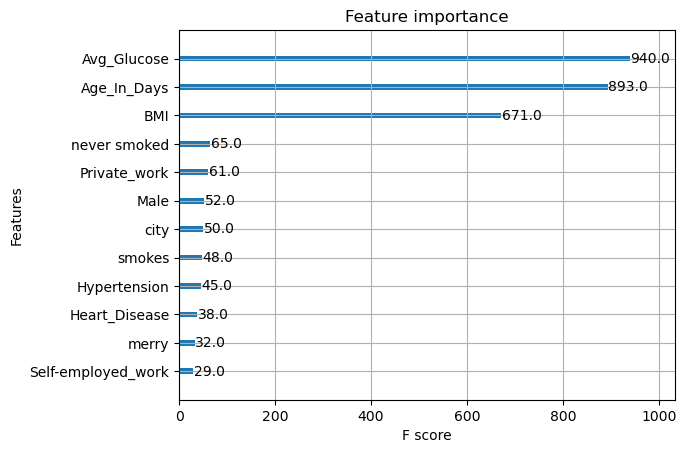

In [21]:
from xgboost import plot_importance

plot_importance(xgb_clf)
plt.show()

 ### Remove less important features
['Never_worked','child_nowork','Self-employed_work','merry']

In [32]:
X1 = df_in.drop(['ID','Stroke','Never_worked','child_nowork','Self-employed_work','merry'],axis=1)
y = df_in['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.4, random_state=41)

#Compare the models_part
xgb_clf = XGBClassifier(scale_pos_weight=(len(y) - np.sum(y))/np.sum(y))
xgb_clf.fit(X_train, y_train)
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
    
print("--train set performance--")
print("accuracy score:",accuracy_score(y_train, y_train_pred))
print("precision score:",precision_score(y_train, y_train_pred))
print("recall score:",recall_score(y_train, y_train_pred))
print("f1 score:",f1_score(y_train, y_train_pred))
print("matthews corrcoef:", matthews_corrcoef(y_train,y_train_pred))
print("Classification report:\n", classification_report(y_train,y_train_pred))
    
print("--test set performance--")
print("accuracy score:",accuracy_score(y_test, y_test_pred))
print("precision score:",precision_score(y_test, y_test_pred))
print("recall score:",recall_score(y_test, y_test_pred))
print("f1 score:",f1_score(y_test, y_test_pred))
print("matthews corrcoef:", matthews_corrcoef(y_test,y_test_pred))
print("Classification report:\n", classification_report(y_test,y_test_pred))

--train set performance--
accuracy score: 0.9563196311947753
precision score: 0.2985811227637261
recall score: 1.0
f1 score: 0.4598574821852732
matthews corrcoef: 0.5341272228045618
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     25546
           1       0.30      1.00      0.46       484

    accuracy                           0.96     26030
   macro avg       0.65      0.98      0.72     26030
weighted avg       0.99      0.96      0.97     26030

--test set performance--
accuracy score: 0.9290653451653798
precision score: 0.06851851851851852
recall score: 0.24749163879598662
f1 score: 0.10732414793328497
matthews corrcoef: 0.10153776738377697
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     17055
           1       0.07      0.25      0.11       299

    accuracy                           0.93     17354
   macro avg       0.53  

#### threshold tunning (test)
Precision/Recall trade-off (ROC plot)

In [53]:
(len(y) - np.sum(y))/np.sum(y)

54.407407407407405

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

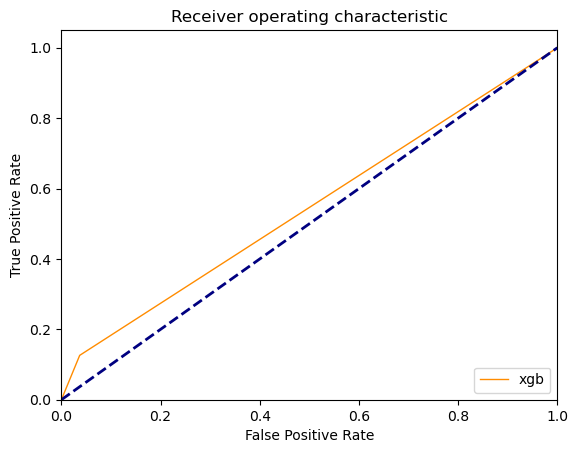

In [31]:
#threshold=60
#xgb_clf = XGBClassifier(scale_pos_weight=threshold)
xgb_clf = XGBClassifier(scale_pos_weight=(len(y) - np.sum(y))/np.sum(y))
#rf_clf = RandomForestClassifier(random_state=42, n_estimators=200,max_depth=4)

y_scores = cross_val_predict(xgb_clf, X_train, y_train, cv=3)
#y_scores_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3)

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw = 1, label='xgb')
#plt.plot(fpr_rf, tpr_rf,'b:', lw = 1, label='rf')
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('')
plt.legend(loc="lower right")
plt.show()

In [26]:
# random test
threshold=30
xgb_clf = XGBClassifier(scale_pos_weight=threshold)
xgb_clf.fit(X_train, y_train)
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
    
print("--train set performance--")
print("accuracy score:",accuracy_score(y_train, y_train_pred))
print("precision score:",precision_score(y_train, y_train_pred))
print("recall score:",recall_score(y_train, y_train_pred))
print("f1 score:",f1_score(y_train, y_train_pred))
print("matthews corrcoef:", matthews_corrcoef(y_train,y_train_pred))
print("Classification report:\n", classification_report(y_train,y_train_pred))

print("--test set performance--")
print("accuracy score:",accuracy_score(y_test, y_test_pred))
print("precision score:",precision_score(y_test, y_test_pred))
print("recall score:",recall_score(y_test, y_test_pred))
print("f1 score:",f1_score(y_test, y_test_pred))
print("matthews corrcoef:", matthews_corrcoef(y_test,y_test_pred))
print("Classification report:\n", classification_report(y_test,y_test_pred))    

--train set performance--
accuracy score: 0.9718017671917019
precision score: 0.3973727422003284
recall score: 1.0
f1 score: 0.5687426556991775
matthews corrcoef: 0.6212529571817864
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     25546
           1       0.40      1.00      0.57       484

    accuracy                           0.97     26030
   macro avg       0.70      0.99      0.78     26030
weighted avg       0.99      0.97      0.98     26030

--test set performance--
accuracy score: 0.9430102570012677
precision score: 0.06218274111675127
recall score: 0.16387959866220736
f1 score: 0.09015639374425023
matthews corrcoef: 0.07534489650480891
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     17055
           1       0.06      0.16      0.09       299

    accuracy                           0.94     17354
   macro avg       0.52  

By changing the threshold, it helps the balance of precision and f1 score on tarining set, but the results getting worse not on test set.

#### hypeparameter tunning - GridSearchCV 

In [23]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    scale_pos_weight=(len(y) - np.sum(y))/np.sum(y),
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 300, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 300, 40)},
             scoring='roc_auc', verbose=True)

In [26]:
print ('The best parameters:')
print ('{}\n'. format(grid_search.best_params_))

The best parameters:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}



In [47]:
xgb_clf = XGBClassifier(scale_pos_weight=(len(y) - np.sum(y))/np.sum(y), max_depth=2, learning_rate=0.05, n_estimators=100)
xgb_clf.fit(X_train, y_train)
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
    
print("--train set performance--")
print("accuracy score:",accuracy_score(y_train, y_train_pred))
print("precision score:",precision_score(y_train, y_train_pred))
print("recall score:",recall_score(y_train, y_train_pred))
print("f1 score:",f1_score(y_train, y_train_pred))
print("matthews corrcoef:", matthews_corrcoef(y_train,y_train_pred))
print("Classification report:\n", classification_report(y_train,y_train_pred))

print("--test set performance--")
print("accuracy score:",accuracy_score(y_test, y_test_pred))
print("precision score:",precision_score(y_test, y_test_pred))
print("recall score:",recall_score(y_test, y_test_pred))
print("f1 score:",f1_score(y_test, y_test_pred))
print("matthews corrcoef:", matthews_corrcoef(y_test,y_test_pred))
print("Classification report:\n", classification_report(y_test,y_test_pred))  

--train set performance--
accuracy score: 0.7290049942374184
precision score: 0.056799784133837024
recall score: 0.8698347107438017
f1 score: 0.10663627152988855
matthews corrcoef: 0.17845188428017483
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84     25546
           1       0.06      0.87      0.11       484

    accuracy                           0.73     26030
   macro avg       0.53      0.80      0.47     26030
weighted avg       0.98      0.73      0.83     26030

--test set performance--
accuracy score: 0.7234067073873458
precision score: 0.0501698980611633
recall score: 0.8394648829431438
f1 score: 0.0946812523576009
matthews corrcoef: 0.1611134268642519
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84     17055
           1       0.05      0.84      0.09       299

    accuracy                           0.72     17354
   macro a